In [48]:
import cirq
from cirq.ops import CZ, H, CNOT, CZPowGate, X, Y, Z
import numpy as np
from numpy.linalg import multi_dot
import sympy
import matplotlib.pyplot as plt

In [49]:
flag1 = cirq.NamedQubit('flag1')
a = cirq.NamedQubit('a')
b = cirq.NamedQubit('b')
flag2 = cirq.NamedQubit('flag2')

In [50]:
#CZ and CRn gadgets with X error on input qubit 1

def cz_circuit(meas=True):
    yield X(a) #X error on input qubit 1
    yield H(flag2)
    yield CNOT(a, flag1), CNOT(flag2, b)
    yield CZPowGate(exponent=1)(a,b)
    yield CZ(a, flag2)
    yield CNOT(a, flag1), CNOT(flag2, b)
    yield H(flag2)
    if meas:
        yield cirq.measure(flag1, key='flag1'), cirq.measure(flag2, key='flag2')

def rn_circuit(meas=True):
    RnGate = CZPowGate(exponent=sympy.Symbol('n'))
    yield X(a) #X error on input qubit 1
    yield H(flag2)
    yield CNOT(a, flag1), CNOT(flag2, b)
    yield RnGate(a,b)
    yield CZ(a, flag2)
    yield CNOT(a, flag1), CNOT(flag2, b)
    yield H(flag2)
    if meas:
        yield cirq.measure(flag1, key='flag1'), cirq.measure(flag2, key='flag2')

In [51]:
#for counting number of flags triggered over many reps
def count_ones(number):
    return number.count('1')

In [52]:
reps = 200

#construct Rn circuit
circuit = cirq.Circuit()
circuit.append(rn_circuit())
print(circuit)

#simlate
simulator = cirq.Simulator()
resolvers = [cirq.ParamResolver({'n': 1/2**(y-1)}) for y in range(1,11)]
result = simulator.run_sweep(program=circuit, params=resolvers, repetitions=reps)

#clean up output
resbits = []
for res in result:
    rawstr = str(res)
    resbits.append([string[6:] for string in rawstr.split()])

#flags triggered
flag1_x = []
flag2_x = []
for flags in resbits:
    flag1_x.append(count_ones(flags[0]))
    flag2_x.append(count_ones(flags[1]))

              ┌──┐             ┌──┐
a: ───────X────@─────@─────@────@─────────────
               │     │     │    │
b: ────────────┼X────@^n───┼────┼X────────────
               ││          │    ││
flag1: ────────X┼──────────┼────X┼────M───────
                │          │     │
flag2: ───H─────@──────────@─────@────H───M───
              └──┘             └──┘


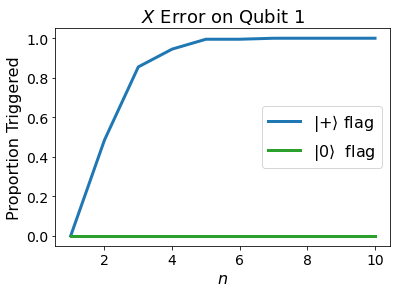

In [53]:
xax = np.linspace(1,10,10)
plt.plot(xax, np.array(flag2_x)/reps, label=r'$|$+$\rangle$ flag', color='tab:blue', lw=3)
plt.plot(xax, np.array(flag1_x)/reps, label=r'$|$0$\rangle$  flag', color='tab:green', lw=3)
plt.title(r'$X$ Error on Qubit 1', fontsize=18)
plt.xlabel(r'$n$', fontsize=16)
plt.ylabel('Proportion Triggered', fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
#plt.savefig('x_q1.pdf')